In [1]:
import pandas as pd
import geopandas as gpd
import requests
import json
from shapely.geometry import shape
from rasterio.crs import CRS
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures

# Getting Data

## Example

In [2]:
def get_eq_data(start_date: datetime,
                end_date: datetime,
                alert: str = None) -> dict:
    
    if alert is not None:
        assert(alert in ['red', 'yellow', 'orange', 'green'])
    url = r"https://earthquake.usgs.gov/fdsnws/event/1/query?"
    params = {"format": "geojson", 
              "starttime": str(start_date), 
              "endtime": str(end_date),
              "alertlevel": alert
             }
    resp = requests.get(url, params=params)
    if resp.status_code != 200:
        raise ValueError(resp.text)
    return resp.json()

In [3]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 2, 1)
alert = 'green'

resp = get_eq_data(start_date, 
                   end_date,
                   alert)
len(resp['features'])

65

In [4]:
def format_data(data: dict) -> gpd.GeoDataFrame:
    if not data['features']:
        return gpd.GeoDataFrame()
    geometry = [shape(f['geometry']) for f in data['features']]
    properties = [f['properties'] for f in data['features']]
    df = gpd.GeoDataFrame(properties, 
                          geometry=geometry, 
                          crs=CRS.from_epsg(4326))
    df['depth'] = df.geometry.apply(lambda x: x.coords[0][2])
    return df

In [5]:
df = format_data(resp)
df.head()

,mag,place,time,updated,tz,url,detail,felt,cdi,mmi,...,types,nst,dmin,rms,gap,magType,type,title,geometry,depth
0,4.9,"84 km SSE of Bengkulu, Indonesia",1612003951473,1618599748040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.0,2.7,3.207,...,",dyfi,losspager,origin,phase-data,shakemap,",NaN,0.479,0.57,31.0,mww,earthquake,"M 4.9 - 84 km SSE of Bengkulu, Indonesia",POINT Z (102.50480 -4.52950 54.90000),54.9
1,5.7,northwest of Australia,1611949675783,1618599741040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.0,5.7,3.911,...,",dyfi,internal-origin,losspager,moment-tensor,...",NaN,4.131,0.98,24.0,mww,earthquake,M 5.7 - northwest of Australia,POINT Z (121.86410 -13.96720 10.00000),10.0
2,5.4,South Shetland Islands,1611929439666,1618599738040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,3.672,...,",losspager,origin,phase-data,shakemap,",NaN,1.661,0.63,54.0,mww,earthquake,M 5.4 - South Shetland Islands,POINT Z (-55.30650 -61.73930 10.00000),10.0
3,5.5,"12 km WSW of Puerto Armuelles, Panama",1611926084617,1660012856811,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,3.0,5.3,6.059,...,",dyfi,losspager,moment-tensor,origin,phase-dat...",NaN,0.390,0.63,117.0,mww,earthquake,"M 5.5 - 12 km WSW of Puerto Armuelles, Panama",POINT Z (-82.96690 8.23410 10.00000),10.0
4,5.7,"12 km SW of Puerto Armuelles, Panama",1611924098711,1619853098423,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,16.0,6.6,6.375,...,",dyfi,internal-origin,losspager,moment-tensor,...",NaN,0.419,0.68,79.0,mww,earthquake,"M 5.7 - 12 km SW of Puerto Armuelles, Panama",POINT Z (-82.95000 8.20450 8.00000),8.0


(-180.0, 180.0)

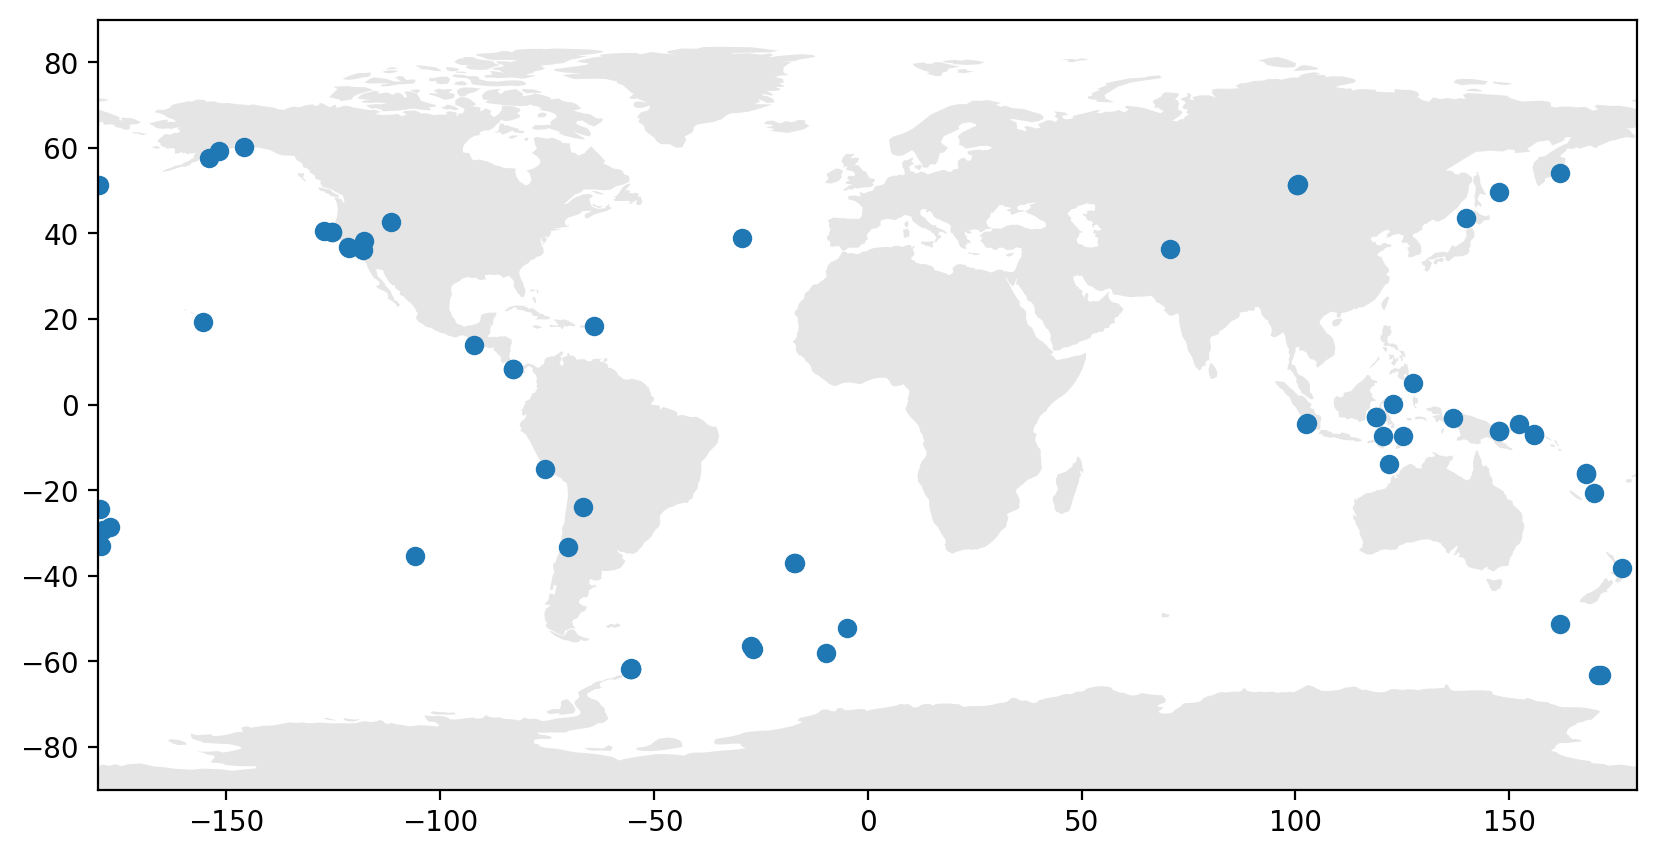

In [6]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=200)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='black', zorder=1, alpha=.1)

df.plot(ax=ax)
ax.set_ylim(-90, 90)
ax.set_xlim(-180, 180)


## All data

In [33]:
start_date_all = datetime(2014, 1, 1)
end_date_all = datetime(2023, 4, 14)
alerts_all = ['red', 'yellow', 'orange', 'green']

In [34]:
N = int(np.ceil((end_date_all - start_date_all).days / 30))
step = 30

dates = [(start_date_all + timedelta(days=(k * step)), 
          start_date_all + timedelta(days=((k+1) * step))) for k in range(N)]
inputs = [[start, end, alert] for alert in alerts_all for (start, end) in dates]

In [35]:
json_data = [get_eq_data(start, end, alert) for (start, end, alert) in tqdm(inputs)]

## Don't use multithread because you will get error of too many requests
## https://geohazards.usgs.gov/pipermail/realtime-feeds/2022-January/000028.html
# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     json_data = list(tqdm(executor.map(lambda i: get_eq_data(*i), inputs), total=len(inputs)))

len(json_data)

100%|█████████████████████████████████████████████| 452/452 [03:16<00:00,  2.30it/s]


452

In [74]:
dfs = [format_data(d) for d in tqdm(json_data)]
df = pd.concat(dfs, axis=0).reset_index(drop=True)

100%|████████████████████████████████████████████| 452/452 [00:00<00:00, 570.94it/s]


Text(1179.8627682002355, 0.5, 'Latitude')

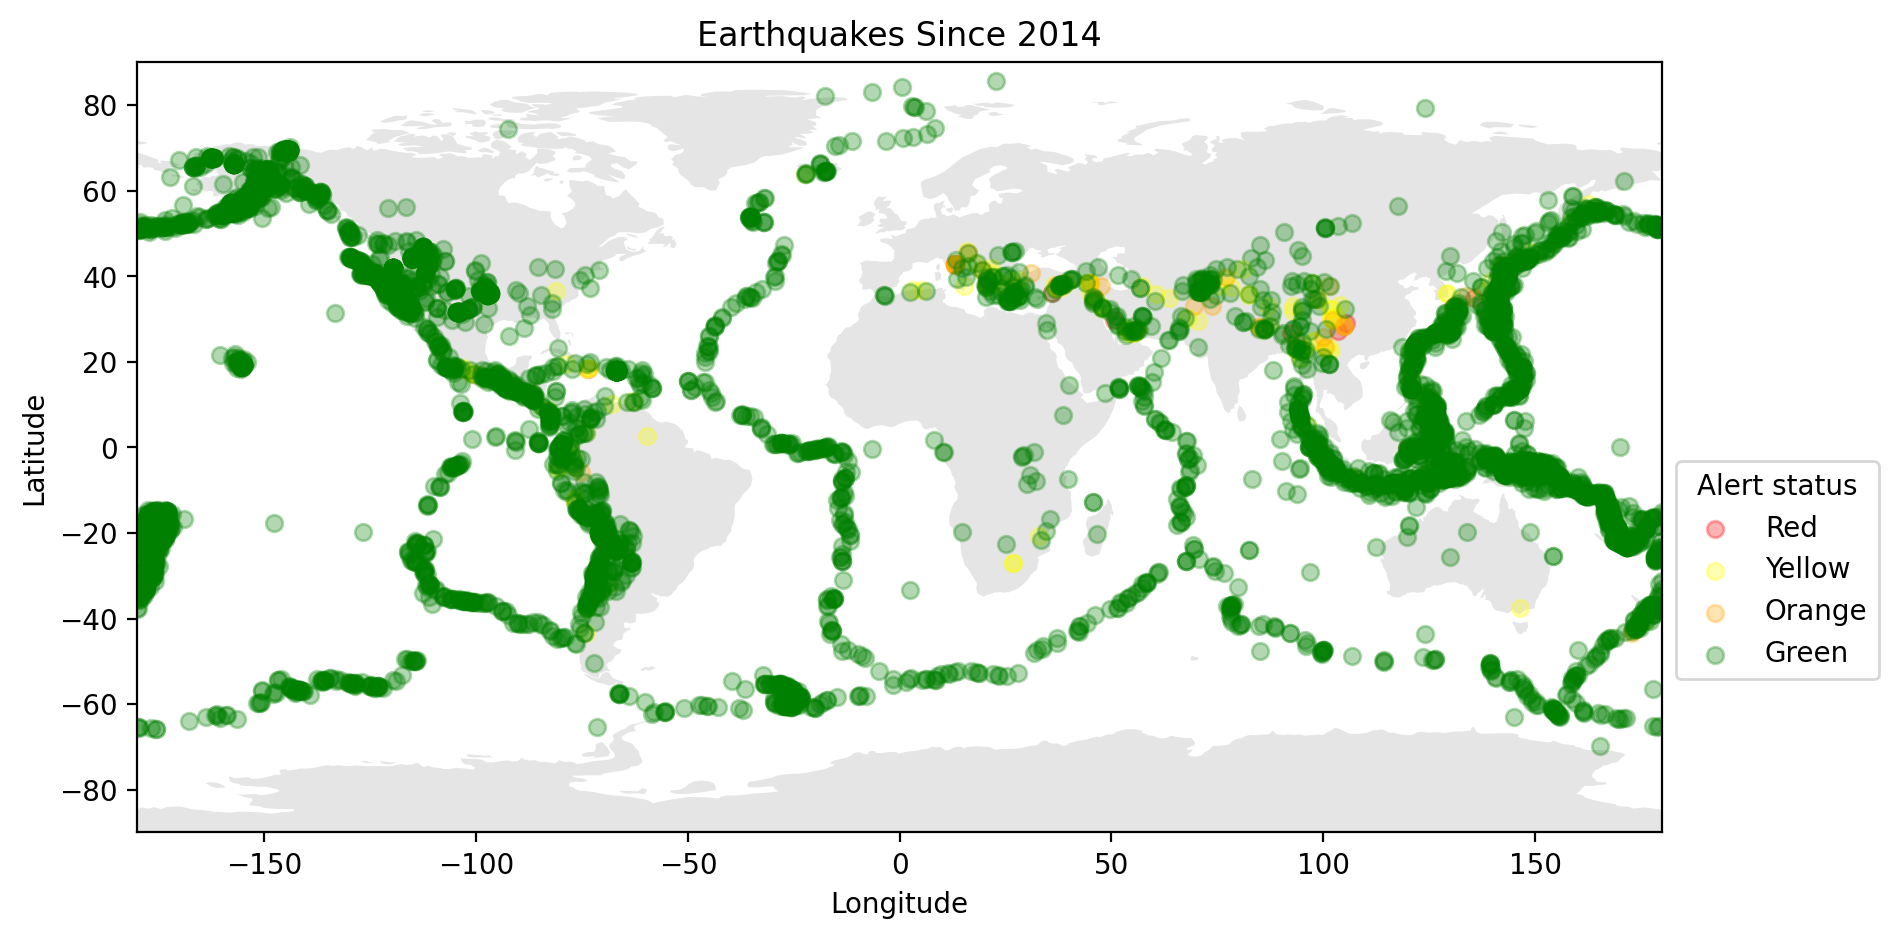

In [75]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=200)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='black', zorder=1, alpha=.1)

for alert in alerts_all:
    df[df.alert==alert].plot(ax=ax, 
                             label=f'{alert.capitalize()}',
                             color=alert,
                             alpha=.3
                             )

ax.set_ylim(-90, 90)
ax.set_xlim(-180, 180)
ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 10}, title='Alert status')
ax.set_title('Earthquakes Since 2014')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [76]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_geo_b = world.geometry.unary_union.buffer(.5)

total EQs after filtering:  204


Text(1217.54208647013, 0.5, 'Latitude')

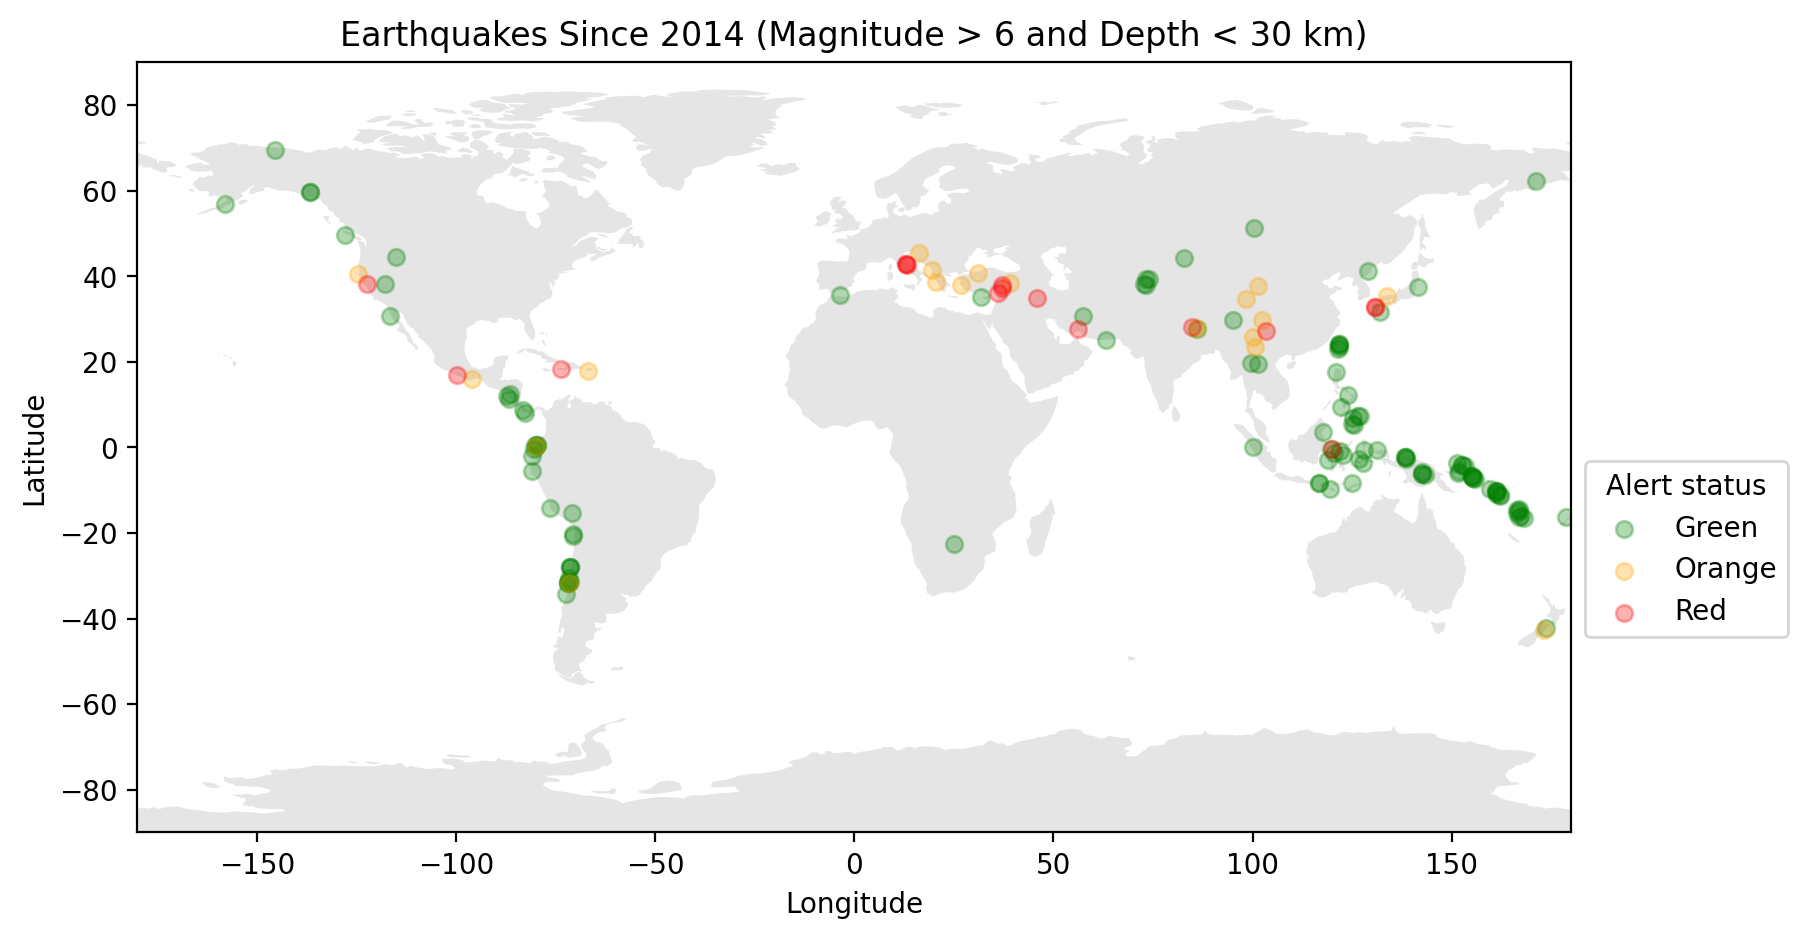

In [77]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=200)
world.plot(ax=ax, color='black', zorder=1, alpha=.1)

df_f = df[(df.mag > 6) & (df.depth < 30)].reset_index(drop=True)
ind = df_f.intersects(world_geo_b)
df_f = df_f[ind].reset_index(drop=True)
print('total EQs after filtering: ', df_f.shape[0])

for alert in ['green', 'orange', 'red']:
    df_f[df_f.alert==alert].plot(ax=ax, 
                                 label=f'{alert.capitalize()}',
                                 color=alert,
                                 alpha=.3
                                 )

ax.set_ylim(-90, 90)
ax.set_xlim(-180, 180)
ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 10}, title='Alert status')
ax.set_title('Earthquakes Since 2014 (Magnitude > 6 and Depth < 30 km)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [78]:
df_f.head()

,mag,place,time,updated,tz,url,detail,felt,cdi,mmi,...,types,nst,dmin,rms,gap,magType,type,title,geometry,depth
0,6.02,South Napa,1408875644070,1651601875653,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,16679,7.6,8.197,...,",cap,dyfi,finite-fault,focal-mechanism,general...",369.0,0.03604,0.18,28,mw,earthquake,M 6.0 - South Napa,POINT Z (-122.31233 38.21517 11.12000),11.12
1,6.20,"33 km WSW of Zhaotong, China",1407054613570,1658870434640,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,10,7.3,8.031,...,",cap,dyfi,ground-failure,losspager,moment-tens...",NaN,2.143,1.00,13,mww,earthquake,"M 6.2 - 33 km WSW of Zhaotong, China",POINT Z (103.40860 27.18910 12.00000),12.00
2,7.80,"67 km NNE of Bharatpur, Nepal",1429942285950,1680591210212,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1120,8.2,8.718,...,",cap,dyfi,finite-fault,general-text,ground-fai...",None,1.857,0.96,12,mww,earthquake,"M 7.8 - 67 km NNE of Bharatpur, Nepal",POINT Z (84.73140 28.23050 8.22000),8.22
3,7.00,"6 km ESE of Kumamoto, Japan",1460737506220,1671796290843,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,81,9.1,8.717,...,",cap,dyfi,finite-fault,general-text,ground-fai...",None,0.349,0.85,32,mww,earthquake,"M 7.0 - 6 km ESE of Kumamoto, Japan",POINT Z (130.75430 32.79060 10.00000),10.00
4,6.20,"2 km SSE of Kumamoto, Japan",1460636795730,1651606459447,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,30,7.9,7.330,...,",cap,dyfi,general-text,impact-text,losspager,m...",None,0.366,1.14,18,mww,earthquake,"M 6.2 - 2 km SSE of Kumamoto, Japan",POINT Z (130.70420 32.78800 9.00000),9.00


See: https://earthquake.usgs.gov/data/comcat/index.php#time

In [80]:
import datetime

df_f['time_of_occ'] = df_f['time'].map(lambda ms: datetime.timedelta(milliseconds=ms) + datetime.datetime(1970, 1, 1))

In [81]:
df_f.head()

,mag,place,time,updated,tz,url,detail,felt,cdi,mmi,...,nst,dmin,rms,gap,magType,type,title,geometry,depth,time_of_occ
0,6.02,South Napa,1408875644070,1651601875653,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,16679,7.6,8.197,...,369.0,0.03604,0.18,28,mw,earthquake,M 6.0 - South Napa,POINT Z (-122.31233 38.21517 11.12000),11.12,2014-08-24 10:20:44.070
1,6.20,"33 km WSW of Zhaotong, China",1407054613570,1658870434640,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,10,7.3,8.031,...,NaN,2.143,1.00,13,mww,earthquake,"M 6.2 - 33 km WSW of Zhaotong, China",POINT Z (103.40860 27.18910 12.00000),12.00,2014-08-03 08:30:13.570
2,7.80,"67 km NNE of Bharatpur, Nepal",1429942285950,1680591210212,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,1120,8.2,8.718,...,None,1.857,0.96,12,mww,earthquake,"M 7.8 - 67 km NNE of Bharatpur, Nepal",POINT Z (84.73140 28.23050 8.22000),8.22,2015-04-25 06:11:25.950
3,7.00,"6 km ESE of Kumamoto, Japan",1460737506220,1671796290843,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,81,9.1,8.717,...,None,0.349,0.85,32,mww,earthquake,"M 7.0 - 6 km ESE of Kumamoto, Japan",POINT Z (130.75430 32.79060 10.00000),10.00,2016-04-15 16:25:06.220
4,6.20,"2 km SSE of Kumamoto, Japan",1460636795730,1651606459447,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,30,7.9,7.330,...,None,0.366,1.14,18,mww,earthquake,"M 6.2 - 2 km SSE of Kumamoto, Japan",POINT Z (130.70420 32.78800 9.00000),9.00,2016-04-14 12:26:35.730


In [84]:
df_f.columns

Index(['mag', 'place', 'time', 'updated', 'tz', 'url', 'detail', 'felt', 'cdi',
       'mmi', 'alert', 'status', 'tsunami', 'sig', 'net', 'code', 'ids',
       'sources', 'types', 'nst', 'dmin', 'rms', 'gap', 'magType', 'type',
       'title', 'geometry', 'depth', 'time_of_occ'],
      dtype='object')

In [106]:
df_final = df_f[['place', 'depth', 'mag', 'geometry']]
df_final['date'] = df_f['time_of_occ'].dt.date.astype(str)
df_final['time'] = df_f['time_of_occ'].dt.time.astype(str)
df_final.head()

/Users/cmarshak/mambaforge/envs/s1-frame-enumerator/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/cmarshak/mambaforge/envs/s1-frame-enumerator/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,place,depth,mag,geometry,date,time
0,South Napa,11.12,6.02,POINT Z (-122.31233 38.21517 11.12000),2014-08-24,10:20:44.070000
1,"33 km WSW of Zhaotong, China",12.00,6.20,POINT Z (103.40860 27.18910 12.00000),2014-08-03,08:30:13.570000
2,"67 km NNE of Bharatpur, Nepal",8.22,7.80,POINT Z (84.73140 28.23050 8.22000),2015-04-25,06:11:25.950000
3,"6 km ESE of Kumamoto, Japan",10.00,7.00,POINT Z (130.75430 32.79060 10.00000),2016-04-15,16:25:06.220000
4,"2 km SSE of Kumamoto, Japan",9.00,6.20,POINT Z (130.70420 32.78800 9.00000),2016-04-14,12:26:35.730000


In [107]:
df_final.to_csv('earthquakes_since_2014.csv', index=False, )

In [109]:
df_final.to_file('earthquakes_since_2014.geojson', driver='GeoJSON')